# Previsão de Topos e Fundos no Bitcoin
Este notebook apresenta o fluxo completo do projeto ajustado para execução passo a passo com visualização integrada.

## Objetivo
Identificar pontos de reversão (Topos e Fundos) no preço do Bitcoin utilizando indicadores técnicos e modelos de Machine Learning (Regressão Logística, Random Forest e LSTM).

In [2]:
%matplotlib inline
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from data_handler import get_historical_data
from feature_engineering import apply_feature_engineering_mtf, label_zigzag
from model_trainer import train_eval_models, plot_confusion_matrix, plot_predictions_on_price

# Configurações visuais
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

## 1. Coleta de Dados Multitemporais
Para uma análise robusta, coletamos dados de 1h, 4h (base para o modelo) e 1d.

In [3]:
data_dir = 'data'
os.makedirs(data_dir, exist_ok=True)

intervals = ['1h', '4h', '1d']
dfs = {}

for interval in intervals:
    file_path = f'data/btc_historical_{interval}.parquet'
    if not os.path.exists(file_path):
        print(f"Baixando dados {interval}...")
        df_tmp = get_historical_data(symbol='BTCUSDT', interval=interval, days=365)
        df_tmp.to_parquet(file_path, index=False)
        dfs[interval] = df_tmp
    else:
        print(f"Carregando {interval} do arquivo.")
        dfs[interval] = pd.read_parquet(file_path)

print("\nDados carregados com sucesso.")

Carregando 1h do arquivo.
Carregando 4h do arquivo.
Carregando 1d do arquivo.

Dados carregados com sucesso.


## 2. Engenharia de Atributos e Rotulagem (ZigZag)
Nesta etapa, calculamos indicadores técnicos em múltiplos tempos gráficos e definimos os Topos e Fundos usando o algoritmo ZigZag (3% de variação).

In [4]:
print("Processando Features e Rótulos...")
df_processed = apply_feature_engineering_mtf(dfs['1h'], dfs['4h'], dfs['1d'])
df_processed = label_zigzag(df_processed, threshold=0.03)
df_processed = df_processed.dropna().reset_index(drop=True)

print(f"\nTotal de registros: {len(df_processed)}")
print("Distribuição de Rótulos:")
print(df_processed['label'].value_counts().rename({0: 'Nada', 1: 'Topo', 2: 'Fundo'}))

# Salvando o processado para uso
df_processed.to_parquet('data/btc_processed_4h.parquet', index=False)

Processando Features e Rótulos...
Calculando features de 4h (Base)...
Calculando features de referência de 1h e 1d...
Mesclando tempos gráficos na base de 4h...

Total de registros: 1987
Distribuição de Rótulos:
Nada     1784
Topo      104
Fundo      99
Name: label, dtype: int64


In [5]:
df_processed.head()

,timestamp,open,high,low,close,volume,sma_20,rsi,macd_diff,close_vs_sma20,...,macd_diff_lag2,close_vs_sma20_lag1,close_vs_sma20_lag2,rsi_1h,macd_diff_1h,close_vs_sma20_1h,rsi_1d,macd_diff_1d,close_vs_sma20_1d,label
0,2025-02-08 00:00:00,96506.80,96880.00,96335.42,96699.23,2006.38123,97430.1800,44.268032,49.919673,-0.007502,...,117.090136,-0.010574,-0.008002,45.393560,-163.884850,-0.006610,40.068528,-777.895154,-0.04798,0
1,2025-02-08 04:00:00,96699.24,96699.24,95785.09,96209.92,1789.48604,97352.5195,42.290860,11.762531,-0.011737,...,66.564440,-0.007502,-0.010574,42.766413,-74.006509,-0.009392,40.068528,-777.895154,-0.04798,0
2,2025-02-08 08:00:00,96209.92,96293.48,95865.71,96120.00,1164.01705,97256.5195,41.920320,-12.416563,-0.011686,...,49.919673,-0.011737,-0.007502,40.006883,-73.894515,-0.010537,40.068528,-777.895154,-0.04798,0
3,2025-02-08 12:00:00,96120.00,96517.52,95688.00,95843.74,2499.53256,97155.4850,40.739322,-38.430462,-0.013502,...,11.762531,-0.011686,-0.011737,42.650105,-14.952875,-0.003557,40.068528,-777.895154,-0.04798,0
4,2025-02-08 16:00:00,95843.74,96750.00,95749.88,96579.99,1536.63554,97074.5845,45.172499,0.472922,-0.005095,...,-12.416563,-0.013502,-0.011686,45.215262,19.223258,-0.000969,40.068528,-777.895154,-0.04798,0


### 2.1 Visualizando os Rótulos no Preço
Vamos ver como o algoritmo ZigZag identificou os pontos de reversão que serviram de alvo para o modelo.

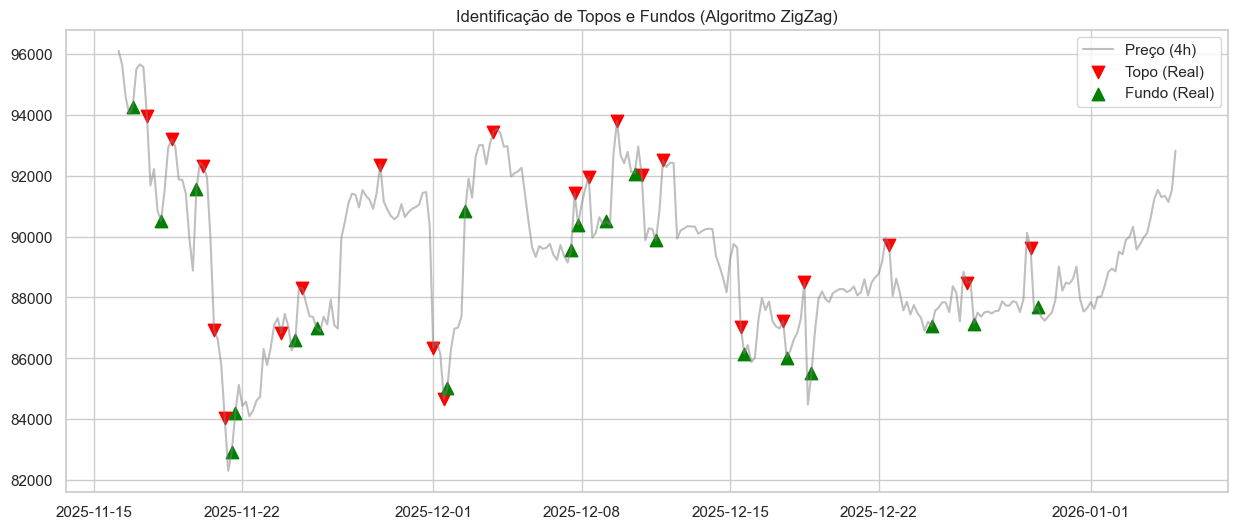

In [6]:
sample = df_processed.tail(300) # Mostrar os últimos 300 períodos de 4h
plt.figure(figsize=(15, 6))
plt.plot(sample['timestamp'], sample['close'], label='Preço (4h)', color='gray', alpha=0.5)

tops = sample[sample['label'] == 1]
bottoms = sample[sample['label'] == 2]

plt.scatter(tops['timestamp'], tops['close'], color='red', label='Topo (Real)', marker='v', s=80)
plt.scatter(bottoms['timestamp'], bottoms['close'], color='green', label='Fundo (Real)', marker='^', s=80)

plt.title("Identificação de Topos e Fundos (Algoritmo ZigZag)")
plt.legend()
plt.show()

## 2.2 Validação Estatística das Labels
Para garantir que o modelo não está tentando aprender padrões aleatórios, realizamos um teste de hipótese (**Teste t de Student**) nas variáveis de **RSI** (Momentum) e **BB_WIDTH** (Volatilidade). 

**Objetivo:** Confirmar se o "p-valor" é menor que 0.05. Se for, podemos afirmar com 95% de confiança que os alvos (Topos e Fundos) são estados estatisticamente diferentes do ruído do mercado.

=== RELATÓRIO DE SIGNIFICÂNCIA ESTATÍSTICA ===

--- Variável: RSI ---
Média Mercado (Nada): 50.9792
Média em Topos: 49.5177 | p-valor vs Nada: 0.36204518 (Não Significativo)
Média em Fundos: 43.5316 | p-valor vs Nada: 0.00000013 (✓ Significativo)
--------------------------------------------------
--- Variável: BB_WIDTH ---
Média Mercado (Nada): 5.1701
Média em Topos: 7.0703 | p-valor vs Nada: 0.00000284 (✓ Significativo)
Média em Fundos: 7.6247 | p-valor vs Nada: 0.00000006 (✓ Significativo)
--------------------------------------------------


C:\Users\dougl\AppData\Local\Temp\ipykernel_18712\2117980348.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=var, data=df_processed, ax=axes[i], palette='viridis')
C:\Users\dougl\AppData\Local\Temp\ipykernel_18712\2117980348.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(['Nada', 'Topo', 'Fundo'])
C:\Users\dougl\AppData\Local\Temp\ipykernel_18712\2117980348.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=var, data=df_processed, ax=axes[i], palette='viridis')
C:\Users\dougl\AppData\Local\Temp\ipykernel_18712\2117980348.py:27: UserWarning: FixedFormatter should only be used together with FixedLoc

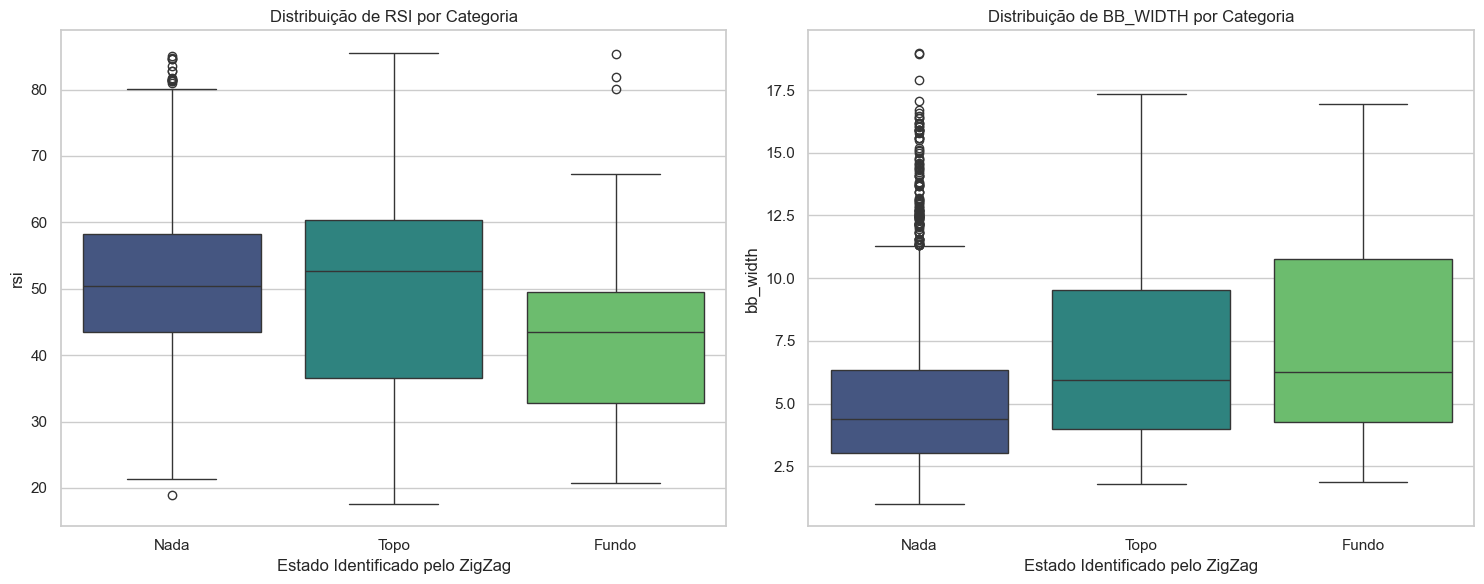

In [7]:
from scipy import stats

# Selecionamos as variáveis que melhor representam o estado do mercado
vars_to_test = ['rsi', 'bb_width']
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

print("=== RELATÓRIO DE SIGNIFICÂNCIA ESTATÍSTICA ===\n")

for i, var in enumerate(vars_to_test):
    # Separação dos grupos baseada nas labels do ZigZag (0=Nada, 1=Topo, 2=Fundo)
    group0 = df_processed[df_processed['label'] == 0][var]
    group1 = df_processed[df_processed['label'] == 1][var]
    group2 = df_processed[df_processed['label'] == 2][var]
    
    # Teste t de Student (Welch's t-test para variâncias desiguais)
    t_top, p_top = stats.ttest_ind(group1, group0, equal_var=False)
    t_bot, p_bot = stats.ttest_ind(group2, group0, equal_var=False)
    
    print(f"--- Variável: {var.upper()} ---")
    print(f"Média Mercado (Nada): {group0.mean():.4f}")
    print(f"Média em Topos: {group1.mean():.4f} | p-valor vs Nada: {p_top:.8f} ({'✓ Significativo' if p_top < 0.05 else 'Não Significativo'})")
    print(f"Média em Fundos: {group2.mean():.4f} | p-valor vs Nada: {p_bot:.8f} ({'✓ Significativo' if p_bot < 0.05 else 'Não Significativo'})")
    print("-" * 50)
    
    # Visualização via Boxplot para o TCC
    sns.boxplot(x='label', y=var, data=df_processed, ax=axes[i], palette='viridis')
    axes[i].set_xticklabels(['Nada', 'Topo', 'Fundo'])
    axes[i].set_title(f'Distribuição de {var.upper()} por Categoria')
    axes[i].set_xlabel('Estado Identificado pelo ZigZag')

plt.tight_layout()
plt.show()

## 3. Treinamento dos Modelos
Agora aplicamos o treinamento e avaliação. A função `train_eval_models` realiza split temporal, escalonamento e busca de hiperparâmetros.

In [8]:
# Executa o treinamento completo
results, y_test, test_dates, test_close = train_eval_models(df_processed)

Tamanho do treino: 1589, Sequências LSTM: (1579, 10, 18)
Tamanho do teste: 398, Sequências LSTM: (388, 10, 18)

Treinando Regressão Logística (Otimizando com Random Search)...
Melhores parâmetros RL: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.0013894954943731374}
Treinando Random Forest (Otimizando com Random Search)...
Melhores parâmetros RF: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10}


Epoch 1/100


40/40 [==============================] - 4s 26ms/step - loss: 1.1497 - accuracy: 0.3373 - val_loss: 1.1628 - val_accuracy: 0.2880
Epoch 2/100
40/40 [==============================] - 0s 7ms/step - loss: 1.1150 - accuracy: 0.5376 - val_loss: 1.1851 - val_accuracy: 0.4399
Epoch 3/100
40/40 [==============================] - 0s 7ms/step - loss: 1.1053 - accuracy: 0.5804 - val_loss: 1.2381 - val_accuracy: 0.3481
Epoch 4/100
40/40 [==============================] - 0s 9ms/step - loss: 1.0805 - accuracy: 0.6587 - val_loss: 1.1522 - val_accuracy: 0.

## 4. Avaliação de Resultados
Abaixo analisamos a performance de cada modelo de forma individual.

### 4.1 Logistic Regression (Baseline Otimizado)

Acurácia: 0.6521
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      0.70      0.79       332
           1       0.24      0.26      0.25        31
           2       0.14      0.56      0.23        25

    accuracy                           0.65       388
   macro avg       0.43      0.50      0.42       388
weighted avg       0.80      0.65      0.71       388



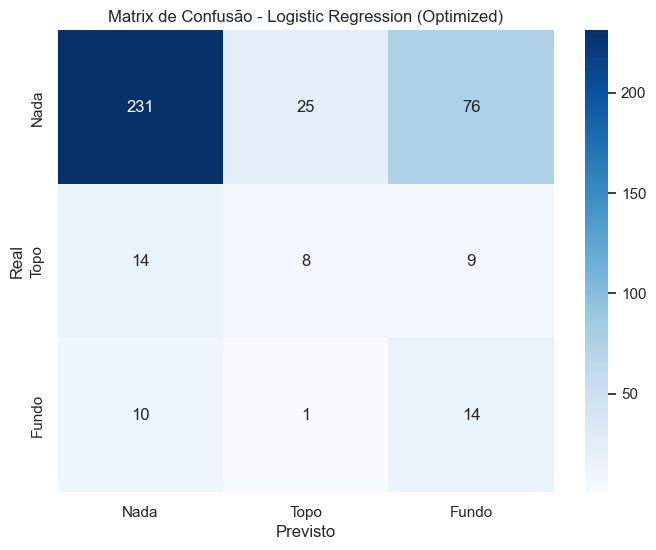

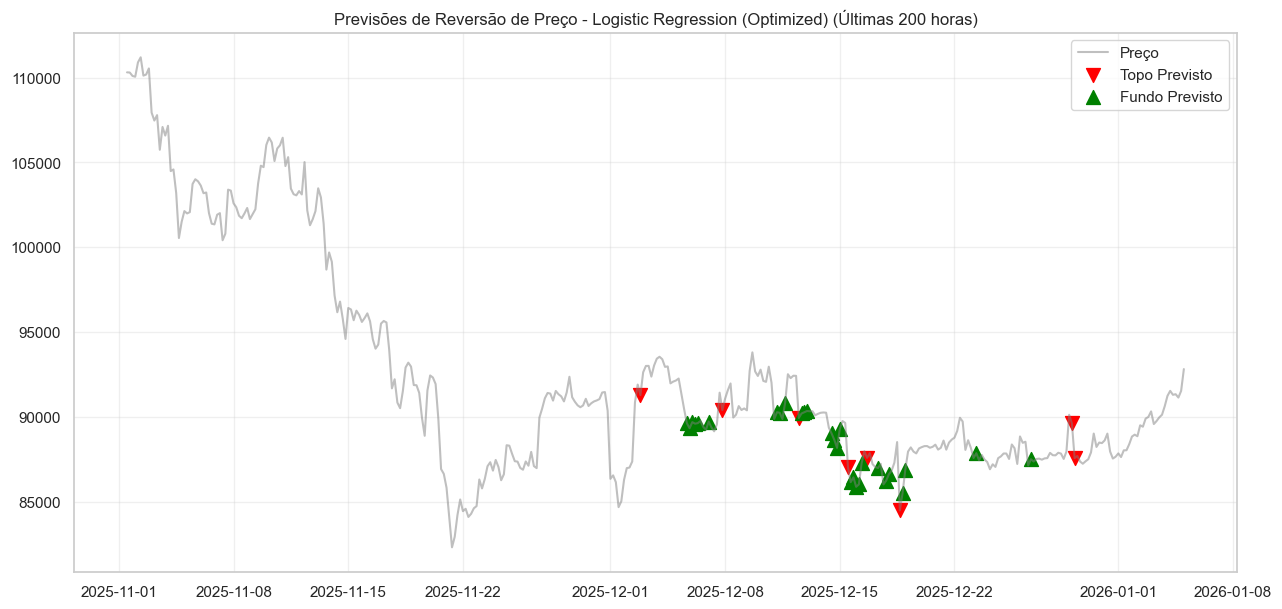

In [9]:
model_name = 'Logistic Regression (Optimized)'
metrics = results[model_name]

print(f"Acurácia: {metrics['accuracy']:.4f}")
print("Relatório de Classificação:")
print(metrics['report'])

plot_confusion_matrix(y_test, metrics['y_pred'], model_name, show=True)
plot_predictions_on_price(test_dates, test_close, y_test, metrics['y_pred'], model_name, show=True)

### 4.2 Random Forest (Ensemble Otimizado)

Acurácia: 0.8299
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       332
           1       0.42      0.26      0.32        31
           2       0.33      0.36      0.35        25

    accuracy                           0.83       388
   macro avg       0.55      0.51      0.52       388
weighted avg       0.82      0.83      0.82       388



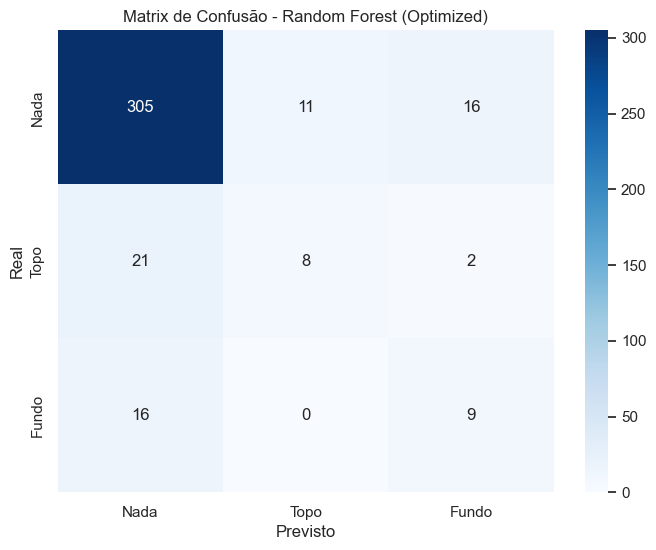

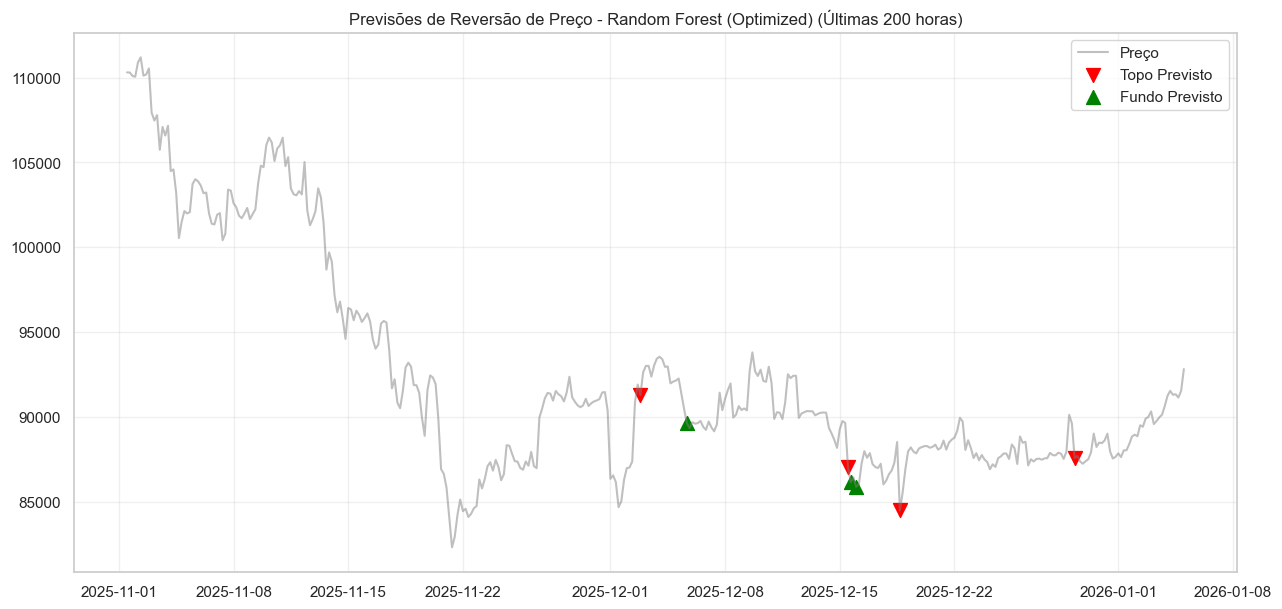

In [10]:
model_name = 'Random Forest (Optimized)'
metrics = results[model_name]

print(f"Acurácia: {metrics['accuracy']:.4f}")
print("Relatório de Classificação:")
print(metrics['report'])

plot_confusion_matrix(y_test, metrics['y_pred'], model_name, show=True)
plot_predictions_on_price(test_dates, test_close, y_test, metrics['y_pred'], model_name, show=True)

### 4.3 Neural Network (LSTM - Deep Learning)

Acurácia: 0.3170
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.87      0.30      0.44       332
           1       0.10      0.26      0.15        31
           2       0.09      0.68      0.15        25

    accuracy                           0.32       388
   macro avg       0.35      0.41      0.25       388
weighted avg       0.76      0.32      0.40       388



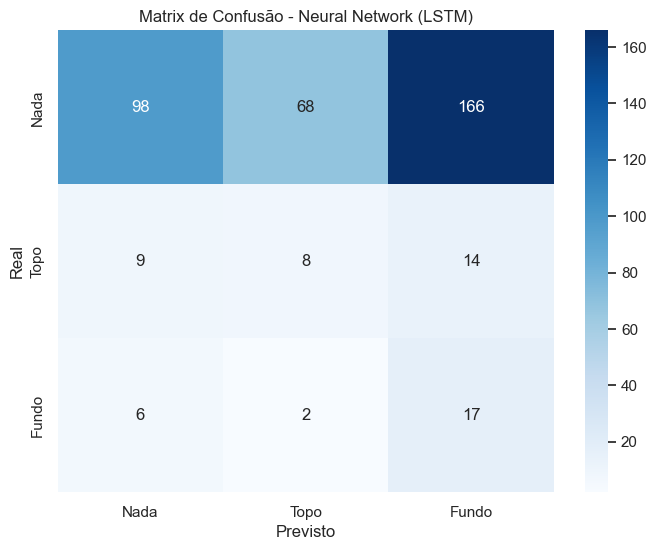

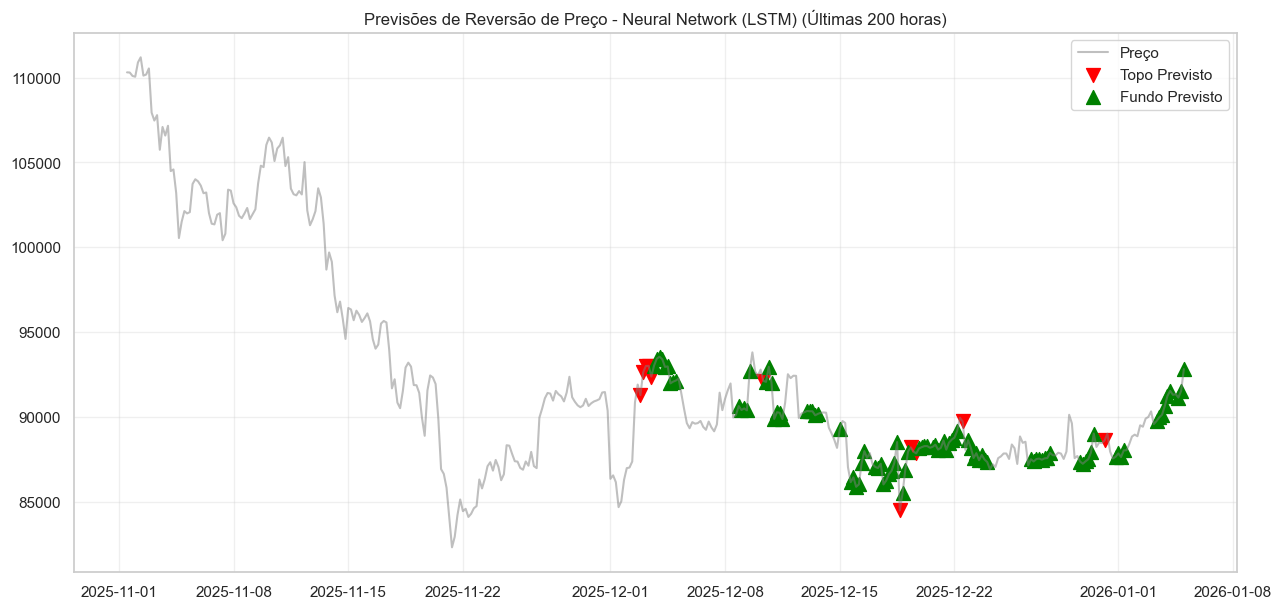

In [11]:
model_name = 'Neural Network (LSTM)'
metrics = results[model_name]

print(f"Acurácia: {metrics['accuracy']:.4f}")
print("Relatório de Classificação:")
print(metrics['report'])

plot_confusion_matrix(y_test, metrics['y_pred'], model_name, show=True)
plot_predictions_on_price(test_dates, test_close, y_test, metrics['y_pred'], model_name, show=True)